In [10]:
import numpy as np
from pandas import read_csv
from scipy.interpolate import interp1d
from numba import njit
import matplotlib.pyplot as plt

### Load vdri file from Vecto

In [11]:
input_file = "inputs/LongHaul_drivingcycle.vdri"

In [12]:
# Vehicle Simulation Parameters (Notebook Cell 1)
motor_power = 352367.5316      # Max motor power in W
fr = 0.00385                   # Rolling friction coefficient
cd_a = 4.325                   # Drag coeff x frontal area in m^2
p_aux = 2300                   # Auxiliary power in W
eta = 0.85                     # Powertrain efficiency

decmax = 1                     # Max deceleration (m/s^2)
accmax = 1                     # Max acceleration (m/s^2)

g = 9.81                       # Gravity (m/s^2)
rho = 1.188                    # Air density (kg/m^3)

mass_range = (10000, 40000)     # Min and max GVW in kg

In [13]:
class VehicleSimulation:
    def __init__(self, params):
        self.motor_power = params['motor_power']
        self.fr = params['fr']
        self.cd_a = params['cd_a']
        self.p_aux = params['p_aux']
        self.eta = params['eta']
        self.decmax = params['decmax']
        self.accmax = params['accmax']
        self.g = params['g']
        self.rho = params['rho']

        drivingcycle = read_csv(params['input_file'])
        self.preprocessing(drivingcycle)

    def preprocessing(self, missionProfile):
        s = missionProfile["<s>"].values
        v = missionProfile["<v>"].values / 3.6
        grad = missionProfile["<grad>"].values
        stop = missionProfile["<stop>"].values
        ds = np.diff(s)

        i2 = np.where(np.diff(v) < 0)[0] + 1
        i1 = np.append([0], i2[:-1])
        v_target = np.zeros(len(v))
        for i1, i2 in zip(i1, i2):
            v_target[i1:i2] = np.minimum(v[i1:i2],
                                         np.sqrt(v[i2] ** 2 + 2 * self.decmax * (s[i2] - s[i1:i2])))

        self.s = s
        self.v = v
        self.grad = grad
        self.stop = stop
        self.vtarget = v_target
        self.ds = ds

    def simulate_consumption(self, m_min, m_max):
        n_points = 4
        gvws = np.linspace(m_min, m_max, n_points)
        cons, v_avgs = zip(*[self.run_sim(gvw) for gvw in gvws])
        f_con = interp1d(gvws, cons)
        f_v_avg = interp1d(gvws, v_avgs)
        return f_con, f_v_avg

    def run_sim(self, gvw):
        return self.run_sim_fast(self.stop, self.ds, self.vtarget, self.grad, self.g, self.rho, self.accmax,
                                 self.fr, self.cd_a, self.motor_power, self.eta, self.p_aux, gvw)

    @staticmethod
    @njit
    def run_sim_fast(stop_arr, ds_arr, vtarget_arr, grad_arr, g, rho, accmax, fr, cd_a, motor_power, eta, p_aux, gvw):
        s = [0]
        t = [0]
        v = [0]
        p = []

        for (stop, ds, vtarget, grad) in zip(stop_arr, ds_arr, vtarget_arr[1:], grad_arr):
            if stop > 0:
                s.append(s[-1])
                t.append(t[-1] + stop)
                v.append(0)
                p.append(0)

            atarget = (vtarget ** 2 - v[-1] ** 2) / (2 * ds)

            f_roll = gvw * g * fr * np.cos(np.arctan(grad / 100))
            f_drag = 0.5 * rho * cd_a * v[-1] ** 2
            f_incl = gvw * g * np.sin(np.arctan(grad / 100))
            f_max = motor_power / v[-1] if v[-1] > 0 else 1e9
            apower = (f_max * eta - f_roll - f_drag - f_incl) / gvw

            a = min(atarget, apower, accmax)
            v_new = np.sqrt(v[-1] ** 2 + 2 * a * ds)
            t_new = t[-1] + 2 * ds / (v[-1] + v_new)
            f_res = gvw * a + f_roll + f_drag + f_incl
            p_new = f_res * v[-1] * eta ** np.sign(-f_res)

            s.append(s[-1] + ds)
            t.append(t_new)
            v.append(v_new)
            p.append(p_new)

        p_bat = [max(p_mot, -motor_power) for p_mot in p]
        t_diff = [t2 - t1 for t1, t2 in zip(t[:-1], t[1:])]
        e_con = [p * dt for p, dt in zip(p_bat, t_diff)]
        e_tot = sum(e_con) + p_aux * t[-1]
        con = e_tot / 3600 / s[-1]
        v_avg = s[-1] / t[-1] * 3.6

        return con, v_avg

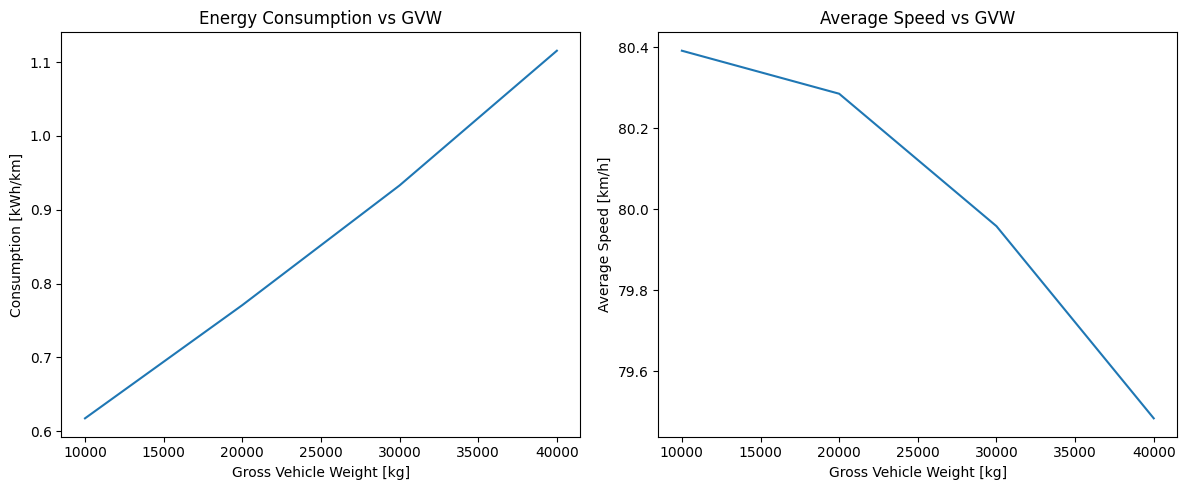

In [14]:
import matplotlib.pyplot as plt

params = {
    'motor_power': motor_power,
    'fr': fr,
    'cd_a': cd_a,
    'p_aux': p_aux,
    'eta': eta,
    'decmax': decmax,
    'accmax': accmax,
    'g': g,
    'rho': rho,
    'input_file': input_file
}

sim = VehicleSimulation(params)
f_con, f_v_avg = sim.simulate_consumption(*mass_range)

masses = np.linspace(*mass_range, 100)
cons = f_con(masses)
speeds = f_v_avg(masses)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(masses, cons)
plt.xlabel('Gross Vehicle Weight [kg]')
plt.ylabel('Consumption [kWh/km]')
plt.title('Energy Consumption vs GVW')

plt.subplot(1, 2, 2)
plt.plot(masses, speeds)
plt.xlabel('Gross Vehicle Weight [kg]')
plt.ylabel('Average Speed [km/h]')
plt.title('Average Speed vs GVW')

plt.tight_layout()
plt.show()
